Bayesian Optimization is a probabilistic model-based optimization that is used to optimize black-box objective function (don't know how the model functions) by learning from previous attempts. It uses a combination of exploration and exploitation to figure out the where the next data point would be. As long as the black-box objective function allows for an input of parameters, and produces an output, almost any model can be used with bayesian optimization to find the best parameters for the model. 

Bayesian Optimization is a probabilistic model approximator that handles uncertainty within dataset well. This is due to the fact that Bayesian Optimization works well with black-box functions that are expensive to evaluate to determine a good approximate.

# Importing Basic Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [479]:
#several libraries to choose from to implement bayesian optimization method
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical       #requires this to explain the search space for the two methods above
from hyperopt import fmin,tpe, hp, Trials, STATUS_OK
from bayes_opt import BayesianOptimization

### Install Bayesian libraries

In [1]:
!pip install scikit-optimize

   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   ---------------------- ----------------- 61.4/107.8 kB 1.6 MB/s eta 0:00:01
   ---------------------- ----------------- 61.4/107.8 kB 1.6 MB/s eta 0:00:01
   ------------------------- ------------- 71.7/107.8 kB 491.5 kB/s eta 0:00:01
   -------------------------------------- 107.8/107.8 kB 567.2 kB/s eta 0:00:00


In [7]:
!pip install bayesian_optimization

In [5]:
!pip install hyperopt

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 660.6 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.6 MB 825.8 kB/s eta 0:00:02
   - -------------------------------------- 0.1/1.6 MB 787.7 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.6 MB 658.7 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.6 MB 658.7 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.6 MB 658.7 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.6 MB 658.7 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.6 MB 590.8 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.6 MB 627.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.6 MB 627.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.6 MB 627.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.6 MB 627.5 kB/s eta 0:0

# Preparing the Data

In [108]:
#reading the dataset
gold=pd.read_csv("gld_price_data.csv")
gold=gold.drop(columns=['Date'])
gold.head()

,SPX,GLD,USO,SLV,EUR/USD
0,1447.160034,84.860001,78.470001,15.180,1.471692
1,1447.160034,85.570000,78.370003,15.285,1.474491
2,1411.630005,85.129997,77.309998,15.167,1.475492
3,1416.180054,84.769997,75.500000,15.053,1.468299
4,1390.189941,86.779999,76.059998,15.590,1.557099


In [110]:
#checking data
gold.isna().sum()

SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

In [112]:
gold.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [114]:
gold.corr()

,SPX,GLD,USO,SLV,EUR/USD
SPX,1.000000,0.049345,-0.591573,-0.274055,-0.672017
GLD,0.049345,1.000000,-0.186360,0.866632,-0.024375
USO,-0.591573,-0.186360,1.000000,0.167547,0.829317
SLV,-0.274055,0.866632,0.167547,1.000000,0.321631
EUR/USD,-0.672017,-0.024375,0.829317,0.321631,1.000000


In [124]:
#splitting data
x=gold[['SPX','USO','SLV','EUR/USD']]
y=gold['GLD']

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,random_state=123)

# Model Development

Bayesian Optimization is a hyperparameter tuning method. Similar to RandomSearchCV or GridSearchCV, they take the hyperparameters of the model and find the model that produces the best score (the evaluation of the model performance). Bayesian Optimization, in contrast to other hyperparameter tuning, doesn't spend time exploring "bad" hyperparameters, and is considered to be more efficient as it considers what the next parameter should be based on records of previous attempts. An ultimate result of using this method is making less calls (less iterations) to the objective function to find the most optimal results.

In [323]:
#any model would work in this situation, as bayesian is finding optimization within the model
#note this model is the surrogate model used to approximate the objective function 
def objective_gp(params):
    n_estimators, max_depth, min_samples_split = params
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=123,
        n_jobs=-1
    )
    # Use cross-validation to evaluate the model
    score = -cross_val_score(model, xtrain, ytrain, cv=5, scoring='neg_mean_squared_error').mean()           
    #this score can vary based on how you want you model to be optimized. If you want the model to be minimized by MSE or RMSE
    return score

Bayesian Optimization requires defining 4 main parts; the objective function, the surrogate model, the domain space, and the aquisition function.

The objective function is the actual function that is going to be optimized (maximize/minimize). This function is unknown or too expensive to evaluate. It would input the hyperparameters of the model, and would return the cross-validation score. Each of these evaluations, it would require training a machine learning model to the new parameters to calculate the optimial model performance. 

The surrogate model is the probabilistic model that approximates the objective function. This is basically a subsititute model of the actual true model of the data. This surrogate model is continously being updated with each iteration. Typically, the surrogate model is Gaussian Process, unless specified otherwise. 

In [326]:
#the domain space or the search space is like the parameter grid seen in the GridSearchCV
#each of the syntax for these spaces is different for each library you choose to implement
domain_space= [
    Integer(10,200,name='n_estimators'),
    Integer(2,20,name='max_depth'),
    Integer(2,20,name='min_samples_split')
]

The domain space is the hyperparameters of the machine learning model that is to be hypertuned. It defines the bounds within the parameters. This space is similarly found in RandomSearchCV and GridSearchCV. 

The aquisition function is the mathematical function that determines where the next parameters should be based on the surrogate model's predictions and uncertainty estimates. 

In [481]:
# Perform the optimization
result = gp_minimize(func=objective_gp,           # Objective function
                     dimensions=domain_space,     # Search space dimensions
                     n_calls=50,                  # Number of evaluations/ iterations
                     base_estimator='RF',         # Changing the surrogate model from Gaussian Processes to Random Forest
                     acq_func='EI',               # Aquisition Function, default:"gp_hedge"
                     random_state=123)            # Replication #       
                     
print(f"Best Parameters: {result.x}")
print(f"Best Mean Squared Error: {result.fun}")

C:\Users\14073\anaconda3.1\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [112, 7, 9] before, using random point [130, 11, 8]
  warnings.warn(
C:\Users\14073\anaconda3.1\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [110, 7, 9] before, using random point [104, 17, 6]
  warnings.warn(
C:\Users\14073\anaconda3.1\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [110, 7, 9] before, using random point [125, 19, 9]
  warnings.warn(


Best Parameters: [130, 10, 4]
Best Mean Squared Error: 8.162118776773628


Note: gp_minimize with the modification of base_estimator to "RF" has similar results as forest_minimize.

In [483]:
result.x_iters

[[145, 10, 14],
 [147, 11, 16],
 [88, 12, 5],
 [86, 13, 8],
 [57, 15, 13],
 [130, 10, 4],
 [145, 10, 7],
 [103, 15, 8],
 [89, 14, 9],
 [55, 20, 16],
 [118, 19, 9],
 [102, 3, 10],
 [100, 6, 6],
 [112, 2, 9],
 [111, 9, 7],
 [113, 9, 6],
 [112, 9, 4],
 [159, 8, 3],
 [165, 8, 3],
 [111, 8, 5],
 [128, 8, 9],
 [121, 8, 9],
 [109, 8, 9],
 [113, 7, 9],
 [112, 7, 8],
 [115, 7, 3],
 [114, 7, 2],
 [114, 7, 4],
 [112, 7, 9],
 [110, 7, 9],
 [107, 7, 9],
 [130, 11, 8],
 [186, 7, 9],
 [66, 7, 9],
 [112, 7, 3],
 [122, 7, 9],
 [112, 7, 7],
 [104, 17, 6],
 [112, 7, 15],
 [112, 7, 18],
 [125, 19, 9],
 [112, 6, 3],
 [176, 3, 3],
 [112, 6, 9],
 [114, 6, 4],
 [140, 6, 3],
 [21, 5, 7],
 [11, 6, 9],
 [178, 6, 9],
 [108, 6, 9]]

# Comparing the Model

In [485]:
bayes_estimator=RandomForestRegressor(n_estimators=130,max_depth=10, min_samples_split=4,random_state=123) 
bayes_estimator.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=10, min_samples_split=4, n_estimators=130,
                      random_state=123)

In [487]:
ypred=bayes_estimator.predict(xtest)
mse=mean_squared_error(ytest,ypred)
print(mse)

4.236600144967599


# Visualizing the Model

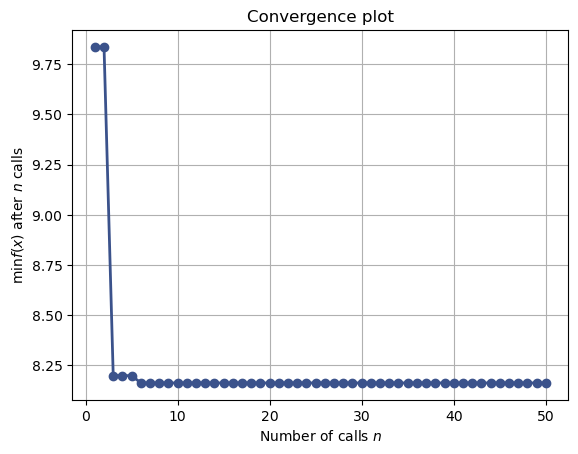

In [489]:
from skopt.plots import plot_convergence
plot_convergence(result)
plt.show()

This model shows the best objective function value observed when we minimize MSE(this is why we use negative MSE). If this model converges, like ours did, we converging to the best solution. A downword trend, is minimizing, and upward, is maximizing, the optimizer.

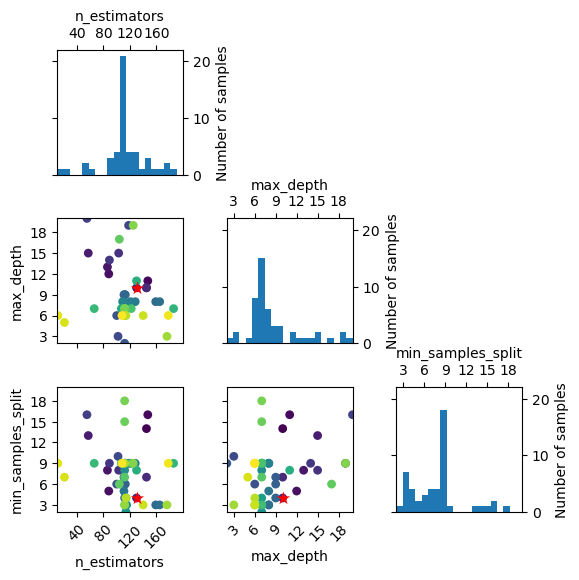

In [491]:
from skopt.plots import plot_evaluations
plot_evaluations(result)
plt.show()

This model shows you how the optimizer is exploring the space. If the plot is like scattered, the optimizer is exploring the space efficiently. The large clusters of data points is when the optimizer learned what produces more efficient results. It shows how what values they pulled from each of the features, and how they decided the next datasets.

<Axes: >

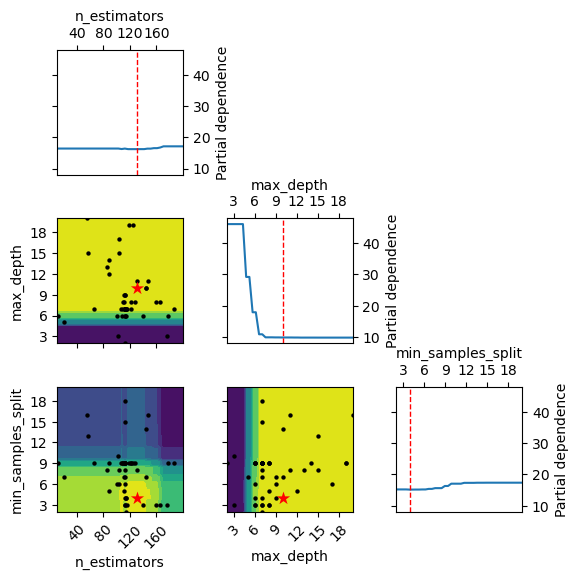

In [493]:
from skopt.plots import plot_objective
plot_objective(result)

A partial dependence plot is the relationship between a feature and it's predicted outcome. The diagonal plots illustrate the relationship between with a single feature and its predicted outcome.The plots with the colors show the interaction between the two features and its predicted outcome to represent more of the gradient of the joint features with the predicted outcome.
By using the partial dependence plot, the gradient helps represent the improvement of the prediction. The color is a huge indicator in determining where the better outcomes were found. The lighter the color, the improvment of the results and the darker, the less optimal. The little star found in this graph and the previous indicates where the model has determined the best results laid.

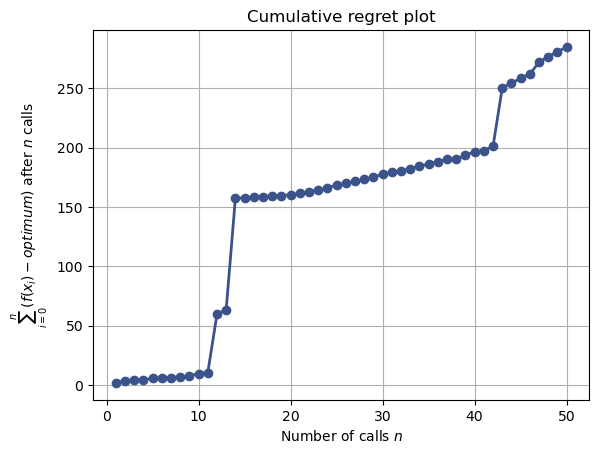

In [494]:
from skopt.plots import plot_regret
plot_regret(result)
plt.show()

In [477]:
from bayes_opt import BayesianOptimization

def objective_bo(n_estimators, max_depth, min_samples_split):
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        random_state=123,
        n_jobs=-1
    )
    # Use cross-validation to evaluate the model
    score = -cross_val_score(model, xtrain, ytrain, cv=5, scoring='neg_mean_squared_error').mean()
    return score

pbounds={'n_estimators': (10,200),
         'max_depth': (2,20),
         'min_samples_split': (2,20)}
         
bayesopt=BayesianOptimization(f=objective_bo,
                              pbounds=pbounds,
                              #acquisition_function='ei'<-default # Aquisition Function(Expected Improvement)
                              random_state=123)

bayesopt.maximize(init_points=5,                # Number of random starting points
                  n_iter=45)                    # Number of optimization iterations                     

print("Best hyperparameters:", bayesopt.max)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 8.341     | 14.54     | 7.151     | 53.1      |
| 2         | 9.917     | 11.92     | 14.95     | 90.39     |
| 3         | 9.851     | 19.65     | 14.33     | 101.4     |
| 4         | 8.948     | 9.058     | 8.177     | 148.5     |
| 5         | 8.243     | 9.894     | 3.074     | 85.63     |
| 6         | 10.62     | 11.06     | 18.99     | 68.25     |
| 7         | 9.245     | 14.92     | 11.64     | 88.33     |
| 8         | 8.739     | 8.559     | 5.788     | 77.76     |
| 9         | 57.35     | 3.907     | 19.55     | 69.49     |
| 10        | 102.3     | 2.65      | 18.93     | 69.53     |
| 11        | 102.3     | 2.092     | 17.92     | 69.87     |
| 12        | 102.2     | 2.139     | 16.41     | 67.44     |
| 13        | 102.2     | 2.215     | 17.48     | 64.13     |
| 14        | 102.2     | 2.686     | 19.62     | 65.78     |
| 15    